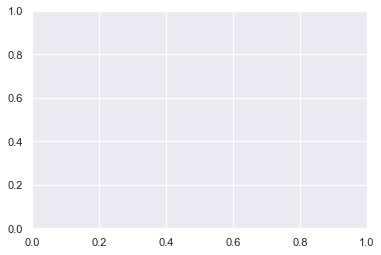

In [173]:
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import unidecode
fig, ax=plt.subplots()
pd.set_option('display.max_columns', None)
import pandas_profiling as pp

In [174]:
df=pd.read_excel('./Data/Processed/Summary/All_years_summary.xlsx')

In [175]:
df2019=df[df.Year==2019]

In [176]:
df.columns.values

array(['S.No', 'Team', 'Year', 'RunsScoredHome', 'OversPlayedHome',
       'RunsConcededHome', 'OversBowledHome', 'Top4', 'HomeBatting',
       'HomeBowling', 'HomeFielding', 'HomeWins', 'RunsConcededAway',
       'OversBowledAway', 'RunsScoredAway', 'OversPlayedAway',
       'AwayBatting', 'AwayBowling', 'AwayFielding', 'AwayWins',
       'RunsScored', 'RunsConceded', 'OversBowled', 'OversPlayed', 'Wins',
       'Batting', 'Bowling', 'Fielding'], dtype=object)

In [177]:
modelset=['Year','Top4','Batting','Bowling', 'Fielding']
dfModel=df[modelset]

In [178]:
X_train=dfModel[dfModel.Year!=2019].drop('Top4', axis=1)
y_train=dfModel[dfModel.Year!=2019].Top4
X_test=dfModel[dfModel.Year==2019].drop('Top4', axis=1)
y_test=dfModel[dfModel.Year==2019].Top4

In [179]:
np.bincount(df.Top4)

array([40, 36])

In [180]:
#plot precicion, recall and thresholds
#predicted_proba[:,1]
def plotPrecisionRecallThreshold(y_test, pred_prob):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, pred_prob) 
   #retrieve probability of being 1(in second column of probs_y)
    pr_auc = metrics.auc(recall, precision)
    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    
def plotROC(y_test,pred_prob):
    fpr, tpr, threshold=metrics.roc_curve(y_test,pred_prob)
    plt.title("ROC Curve")
    sns.lineplot(x=fpr,y=tpr,palette="muted")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    
def areaUnderROC(y_test, pred_prob):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, pred_prob) 
    return metrics.auc(recall, precision)

def cm(y_test,prediction_test):
    arr=metrics.confusion_matrix(y_test,prediction_test)
    df_cm = pd.DataFrame(arr, range(2),range(2))
    #plt.figure(figsize = (10,7))
    sns.set(font_scale=1)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for threshold: .5")

In [181]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model = LogisticRegression(random_state=232,penalty='none', solver='saga')
result = model.fit(X_train, y_train)

In [182]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: ',metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: ',metrics.accuracy_score(y_test, prediction_test))

training accuracy:  0.75
test accuracy:  0.375


In [183]:
df2019['Logistic']=prediction_test
df2019['pLogistic']=model.predict_proba(X_test)[:,1]

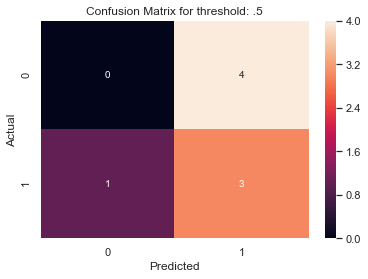

In [184]:
cm(y_test,prediction_test)

area under curve : 0.69


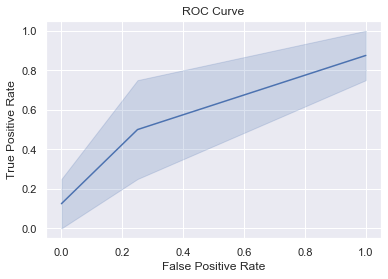

In [185]:
plotROC(y_test, df2019['pLogistic'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pLogistic']) )

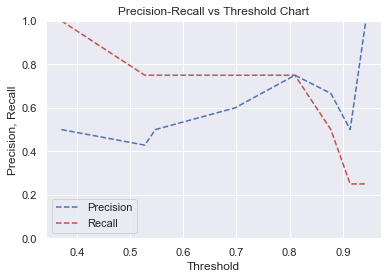

In [186]:
plotPrecisionRecallThreshold(y_test, df2019['pLogistic'])

AxesSubplot(0.125,0.125;0.775x0.755)


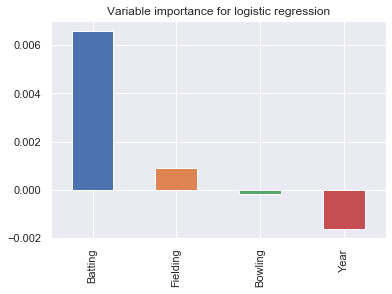

In [187]:
weights = pd.Series(model.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [188]:
#logistic regression CV. L1 Lasso
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(Cs=np.linspace(1e-4,1e-2,50),cv=5,penalty='l1',solver='liblinear', random_state=232)
result = model.fit(X_train, y_train)
model.C_

array([0.00131224])

In [189]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.74
test accuracy: 0.38


In [190]:
df2019['L1Logistic']=prediction_test
df2019['pL1Logistic']=model.predict_proba(X_test)[:,1]

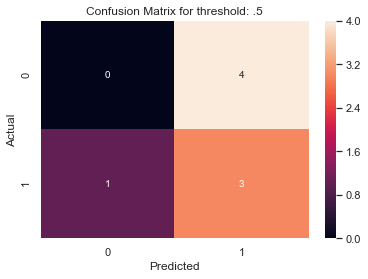

In [191]:
cm(y_test,prediction_test)

area under curve : 0.69


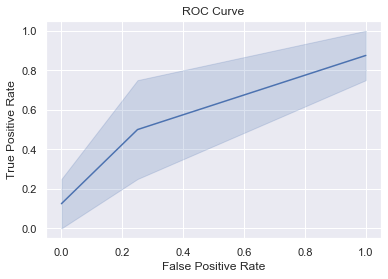

In [192]:
plotROC(y_test, df2019['pL1Logistic'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pL1Logistic']) )

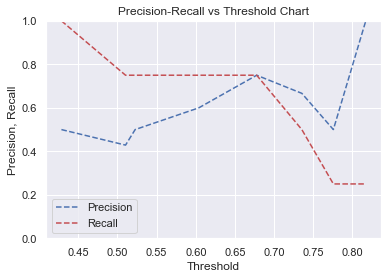

In [193]:
plotPrecisionRecallThreshold(y_test, df2019['pL1Logistic'])

AxesSubplot(0.125,0.125;0.775x0.755)


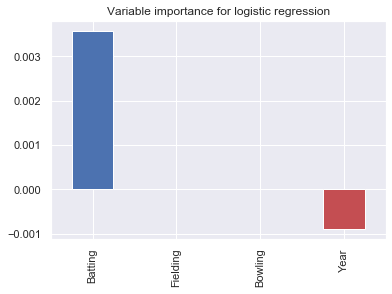

In [194]:
weights = pd.Series(model.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [195]:
#Logistic regression with Ridge CV
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(Cs=np.linspace(1e-7,1e-1,100),cv=5,penalty='l2', random_state=232)
result = model.fit(X_train, y_train)
model.C_

array([0.0010102])

In [196]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.75
test accuracy: 0.38


In [197]:
df2019['L2Logistic']=prediction_test
df2019['pL2Logistic']=model.predict_proba(X_test)[:,1]

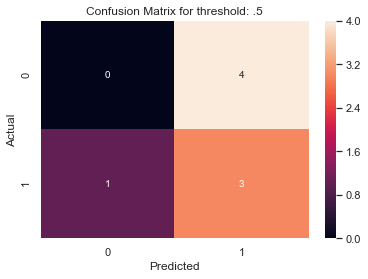

In [198]:
cm(y_test,prediction_test)

area under curve : 0.69


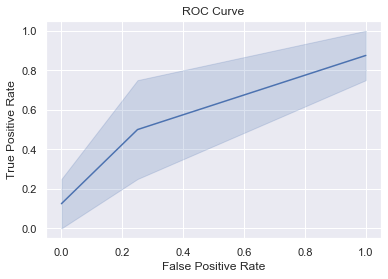

In [199]:
plotROC(y_test, df2019['pL2Logistic'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pL2Logistic']) )

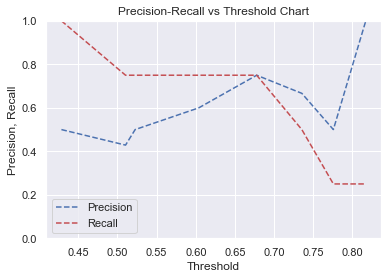

In [200]:
plotPrecisionRecallThreshold(y_test, df2019['pL1Logistic'])

AxesSubplot(0.125,0.125;0.775x0.755)


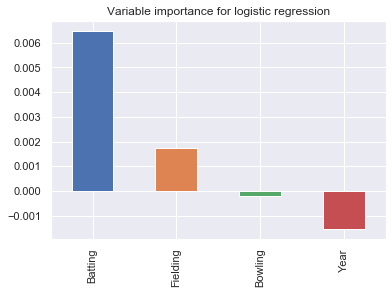

In [201]:
weights = pd.Series(model.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar',title='Variable importance for logistic regression'))

In [202]:
df2019.to_excel('./Reports/2019_predictions.xlsx')

In [203]:
#XGBoost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV   #Perforing grid search
model=GradientBoostingClassifier(random_state=232)

In [204]:
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
#df['logisticCVL1']=model.predict(X)
# Print the prediction accuracy
print('accuracy %.2f' %(metrics.accuracy_score(y_test, prediction_test)))

accuracy 0.25


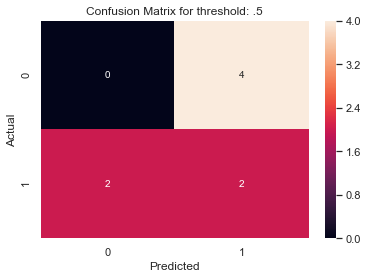

In [205]:
cm(y_test, prediction_test)

In [206]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 1.00
test accuracy: 0.25


In [207]:
df2019['XGBoost']=prediction_test
df2019['pXGBoost']=model.predict_proba(X_test)[:,1]

area under curve : 0.71


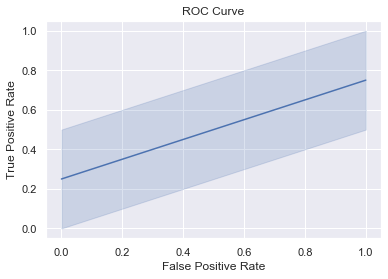

In [208]:
plotROC(y_test, df2019['pXGBoost'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pXGBoost']) )

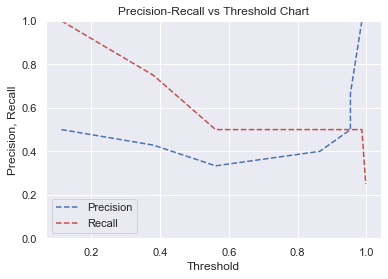

In [209]:
plotPrecisionRecallThreshold(y_test, df2019['pXGBoost'])

In [210]:
model.decision_function(X_test)

array([ 4.32681204,  6.42894704,  3.02454077,  0.24703921, -2.05961225,
        3.02607212,  1.85455263, -0.48801739])

In [211]:
model.score(X_test,y_test)

0.25

In [212]:
df2019['pXGBoost']

68    0.986963
69    0.998388
70    0.953671
71    0.561448
72    0.113085
73    0.953738
74    0.864661
75    0.380361
Name: pXGBoost, dtype: float64

In [213]:
model.feature_importances_

array([0.04486861, 0.43402272, 0.23636265, 0.28474602])

In [ ]:
pd.DataFrame(data={'Feature':X_train.columns.values,'Importance':model.feature_importances_.flatten()})

In [216]:
#Neural Network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(random_state=232,learning_rate='adaptive')
model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=232, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [217]:
prediction_test = model.predict(X_train)
# Print the prediction accuracy
print('training accuracy: %.2f' %metrics.accuracy_score(y_train, prediction_test))
#df['logistic']=model.predict(X)
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print('test accuracy: %.2f' %metrics.accuracy_score(y_test, prediction_test))

training accuracy: 0.63
test accuracy: 0.75


In [218]:
df2019['NN']=prediction_test
df2019['pNN']=model.predict_proba(X_test)[:,1]

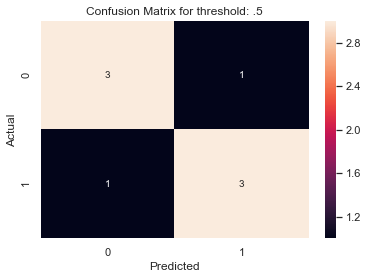

In [219]:
cm(y_test,prediction_test)

area under curve : 0.71


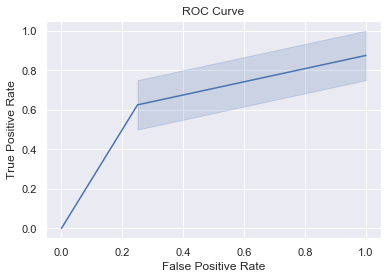

In [220]:
plotROC(y_test, df2019['pNN'])
print('area under curve : %.2f' %areaUnderROC(y_test, df2019['pNN']) )

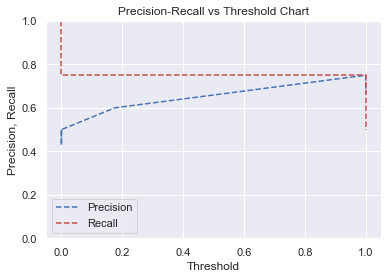

In [221]:
plotPrecisionRecallThreshold(y_test, df2019['pNN'])

In [222]:
prediction_test

array([1, 1, 1, 0, 1, 0, 0, 0])

In [223]:
df2019.head()

,S.No,Team,Year,RunsScoredHome,OversPlayedHome,RunsConcededHome,OversBowledHome,Top4,HomeBatting,HomeBowling,HomeFielding,HomeWins,RunsConcededAway,OversBowledAway,RunsScoredAway,OversPlayedAway,AwayBatting,AwayBowling,AwayFielding,AwayWins,RunsScored,RunsConceded,OversBowled,OversPlayed,Wins,Batting,Bowling,Fielding,Logistic,pLogistic,L1Logistic,pL1Logistic,L2Logistic,pL2Logistic,XGBoost,pXGBoost,NN,pNN
68,69,CSK,2019,140.142857,18.785714,130.285714,19.042857,1,915.000000,621.142857,125.000000,6,157.142857,19.214286,151.714286,19.828571,922.000000,677.142857,129.642857,3,145.928571,143.714286,19.128571,19.307143,9,918.500000,649.142857,127.321429,1,0.943038,1,0.816952,1,0.942106,1,0.986963,1,1.000000
69,70,DD,2019,151.857143,19.357143,154.714286,19.671429,1,781.571429,240.714286,79.285714,3,165.000000,19.671429,163.428571,18.800000,790.071429,238.214286,86.428571,5,157.642857,159.857143,19.671429,19.078571,8,785.821429,239.464286,82.857143,1,0.877346,1,0.735344,1,0.874804,1,0.998388,1,1.000000
70,71,KKR,2019,192.857143,19.914286,185.857143,19.585714,0,836.642857,514.142857,121.785714,3,159.714286,18.328571,159.428571,18.942857,857.142857,444.357143,118.928571,4,176.142857,172.785714,18.957143,19.428571,7,846.892857,479.250000,120.357143,1,0.913706,1,0.775573,1,0.913047,1,0.953671,1,1.000000
71,72,KP,2019,172.142857,19.414286,168.142857,19.771429,0,605.928571,368.714286,76.071429,5,189.428571,19.914286,173.428571,20.000000,629.642857,316.428571,75.357143,1,172.785714,178.785714,19.842857,19.707143,6,617.785714,342.571429,75.714286,1,0.697439,1,0.603886,1,0.694266,1,0.561448,0,0.175228
72,73,MI,2019,171.428571,19.085714,169.428571,20.000000,1,709.214286,537.071429,145.357143,5,155.000000,18.900000,168.714286,20.000000,706.428571,601.285714,143.214286,4,170.071429,162.214286,19.450000,19.542857,9,707.821429,569.178571,144.285714,1,0.809771,1,0.677715,1,0.813363,0,0.113085,1,1.000000


In [224]:
df2019.to_excel('./Reports/2019_predictions.xlsx')